In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting the data 
import seaborn as sns # Advanced data plotting on top of matplotlib
import os


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import cv2
from PIL import Image
from matplotlib import pyplot as plt


In [2]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
#/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv
#/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv
#/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv
#/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv    

**About data**

*images* - a folder of images corresponding to each article_id; images are placed in subfolders starting with the first three digits of the article_id; note, not all article_id values have a corresponding image.

*articles.csv* - detailed metadata for each article_id available for purchase

*customers.csv* - metadata for each customer_id in dataset

*sample_submission.csv* - a sample submission file in the correct format

*transactions_train.csv* - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Your task is to predict the article_ids each customer will purchase during the 7-day period immediately after the training data period.

*target*: Make predictions for all customer_id values found in the sample submission. All customers who made purchases during the test period are scored, regardless of whether they had purchase history in the training data.

Submissions are evaluated according to the Mean Average Precision @ 12 (MAP@12).
For each customer_id observed in the training data, you may predict up to 12 labels for the article_id, which is the predicted items a customer will buy in the next 7-day period after the training time period. 

# EDA

In [3]:
#customers_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv")
#sample_submission = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv" )
#customers_df.head()

In [4]:
#transactions_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")#, nrow=10000)
#print(transactions_df.shape)
#transactions_df.head()
# let's takr peace of data
#transactions_df_sample = transactions_df.iloc[:50000,:].copy()
#transactions_df_sample.shape

In [5]:
articles_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv")
print(articles_df.shape)
articles_df.head().T  

(105542, 25)


,0,1,2,3,4
article_id,108775015,108775044,108775051,110065001,110065002
product_code,108775,108775,108775,110065,110065
prod_name,Strap top,Strap top,Strap top (1),OP T-shirt (Idro),OP T-shirt (Idro)
product_type_no,253,253,253,306,306
product_type_name,Vest top,Vest top,Vest top,Bra,Bra
product_group_name,Garment Upper body,Garment Upper body,Garment Upper body,Underwear,Underwear
graphical_appearance_no,1010016,1010016,1010017,1010016,1010016
graphical_appearance_name,Solid,Solid,Stripe,Solid,Solid
colour_group_code,9,10,11,9,10
colour_group_name,Black,White,Off White,Black,White


In [6]:
def make_image_path(image_id):
    return "../input/h-and-m-personalized-fashion-recommendations/images/0{}/0{}.jpg".format(str(image_id)[:2], image_id)

In [7]:
# will use small sample
articles_df_sample = articles_df.head(500).copy()

In [8]:
# make path
articles_df_sample["image_path"] = articles_df_sample["article_id"].apply(make_image_path)
articles_df_sample["image_path"].head()

0    ../input/h-and-m-personalized-fashion-recommen...
1    ../input/h-and-m-personalized-fashion-recommen...
2    ../input/h-and-m-personalized-fashion-recommen...
3    ../input/h-and-m-personalized-fashion-recommen...
4    ../input/h-and-m-personalized-fashion-recommen...
Name: image_path, dtype: object

# Image Similarity

In [9]:
def draw_images(image_ids):
    img_list = []
    for id in image_ids:
        #image_path = "../input/h-and-m-personalized-fashion-recommendations/images/0{}/0{}.jpg".format(str(id)[:2], id)
        image_path = make_image_path(id)
        #print(image_path)
        img = Image.open(image_path)
        img_list.append(img)

    plt.figure(figsize=(20,5))
    for j in range(len(image_ids)):
        plt.subplot(1, len(image_ids), j+1)
        plt.axis('off')
        plt.imshow(img_list[j])
        plt.title(str(image_ids[j]), loc='center')

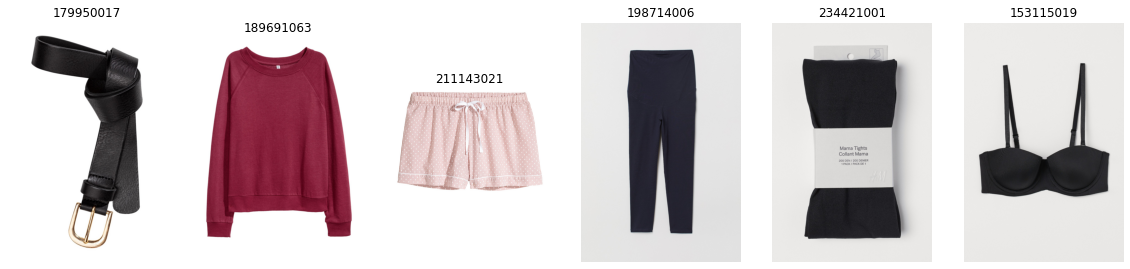

In [10]:
# image examples
draw_images(articles_df_sample.sample(6)['article_id'].values)

# Model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

In [12]:
#from PIL import Image
from torchvision import transforms


transform_resnet = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


class HMDataset_resnet(Dataset):
    
    def __init__(self, imgs_list, transforms = None):
        
        super().__init__()
        self.imgs_list = imgs_list
        self.transforms = transforms
        
        
    def __getitem__(self, index):
    
       
        image_path = self.imgs_list[index]
       
        #Reading image
        try:
            input_image = Image.open(image_path)
        except FileNotFoundError:
            print("FileNotFoundError:", image_path, " black_image will be used instead of it!")
            image_path = "../input/black-image/A_black_image.jpg"
            input_image = Image.open(image_path)

        if self.transforms:
            image = self.transforms(input_image)
            
        
        return image
        
        
        
    def __len__(self):
        return len(self.imgs_list)

In [13]:
#  For RESNET
img_tensors = HMDataset_resnet(articles_df_sample.image_path.values, transform_resnet)

img_data_loader = DataLoader(
    dataset = img_tensors,
    batch_size = 8,
    shuffle=False,
    #sampler = train_random_sampler,
    num_workers = 2,
)

In [14]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [15]:
# dummy layer for replace classification layer in model

class Identity(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x
    
model.fc = Identity()

In [16]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# make embedings of the pictures

img_embs_list = []
for batch in img_data_loader:
    img_embs = model(batch)
    img_embs_list += list(img_embs.detach().numpy())
len(img_embs_list)

FileNotFoundError: ../input/h-and-m-personalized-fashion-recommendations/images/017/0174057028.jpg  black_image will be used instead of it!
FileNotFoundError: ../input/h-and-m-personalized-fashion-recommendations/images/017/0179208001.jpg  black_image will be used instead of it!
FileNotFoundError: ../input/h-and-m-personalized-fashion-recommendations/images/021/0212042043.jpg  black_image will be used instead of it!
FileNotFoundError: ../input/h-and-m-personalized-fashion-recommendations/images/021/0212042066.jpg  black_image will be used instead of it!
FileNotFoundError: ../input/h-and-m-personalized-fashion-recommendations/images/021/0212629004.jpg  black_image will be used instead of it!
FileNotFoundError: ../input/h-and-m-personalized-fashion-recommendations/images/021/0215324023.jpg  black_image will be used instead of it!
FileNotFoundError: ../input/h-and-m-personalized-fashion-recommendations/images/021/0216961011.jpg  black_image will be used instead of it!
FileNotFoundError: .

500

In [18]:
# calculate most similar embedings 

def image_similarity_top_n(img_embs_list, img_num, n):
    
    img_cor_list = []
    for img_emb in img_embs_list:
        img_cor = np.correlate(img_embs_list[img_num], img_emb)
        img_cor_list.append(img_cor[0])
        
    #print(img_cor_list[:3])
    return np.argsort(img_cor_list)[-n-1:-1]

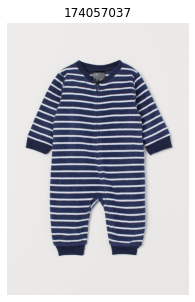

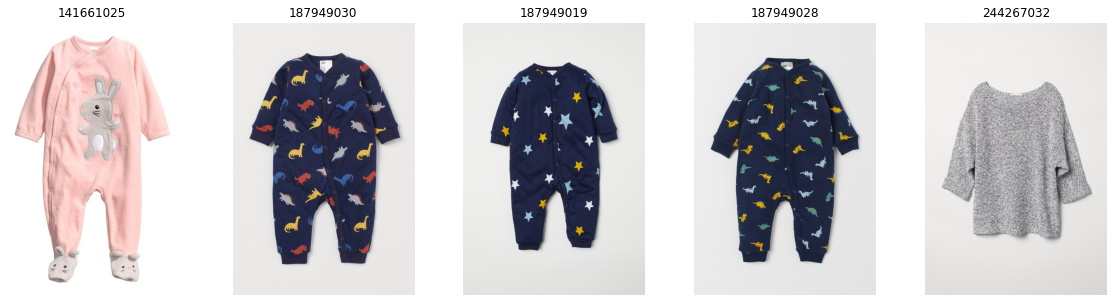

In [19]:
item_num = 95
draw_images([articles_df_sample.iloc[item_num,0]])
id_list = []
for i in image_similarity_top_n(img_embs_list, item_num, 5):
    id_list.append(articles_df_sample.iloc[i,0])
draw_images(id_list)

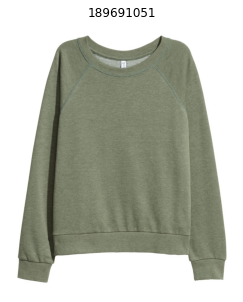

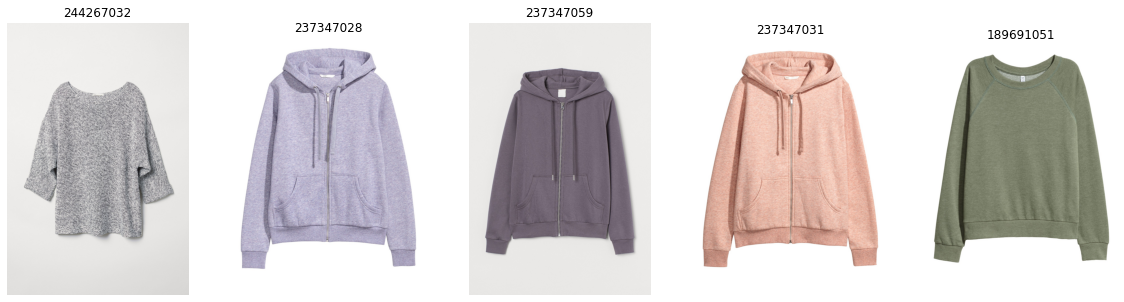

In [20]:
item_num = 195
draw_images([articles_df_sample.iloc[item_num,0]])
id_list = []
for i in image_similarity_top_n(img_embs_list, item_num, 5):
    id_list.append(articles_df_sample.iloc[i,0])
draw_images(id_list)

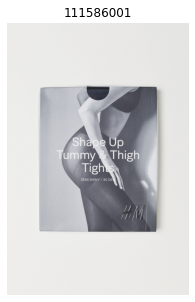

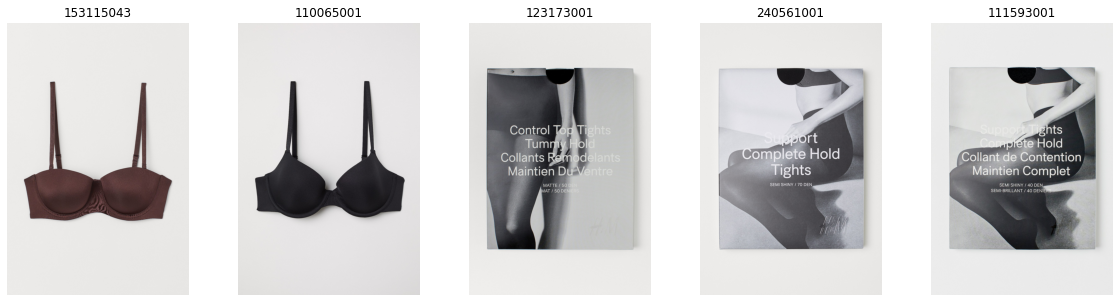

In [21]:
item_num = 8
draw_images([articles_df_sample.iloc[item_num,0]])
id_list = []
for i in image_similarity_top_n(img_embs_list, item_num, 5):
    id_list.append(articles_df_sample.iloc[i,0])
draw_images(id_list)

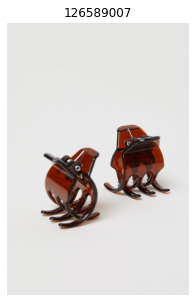

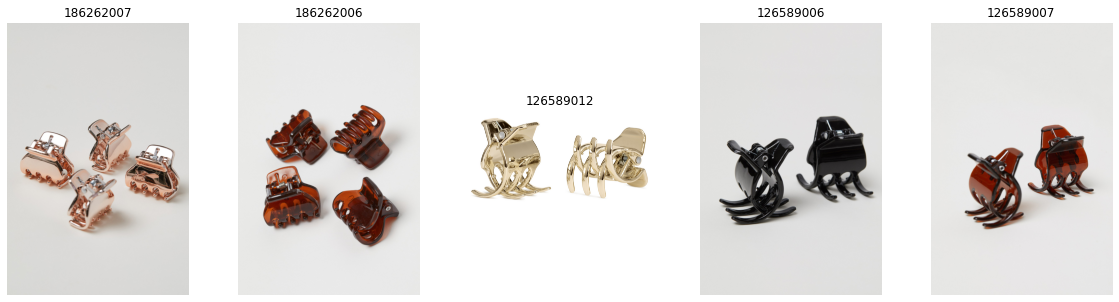

In [22]:
item_num = 29
draw_images([articles_df_sample.iloc[item_num,0]])
id_list = []
for i in image_similarity_top_n(img_embs_list, item_num, 5):
    id_list.append(articles_df_sample.iloc[i,0])
draw_images(id_list)